In [1]:
from pathlib import Path
from course_intro_ocr_t1.data import MidvPackage
from tqdm import tqdm
import numpy as np
import torch
import cv2
import torch.nn as nn
import lightning
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%load_ext tensorboard

In [3]:
DATASET_PATH = Path().absolute().parent.parent / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [4]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_intro_ocr_t1.data.MidvPackage)

In [5]:
# В каждом пакете - 300 штук DataItem
dp = data_packs[0]
di = dp[220]
type(dp), len(dp), type(di)

(course_intro_ocr_t1.data.MidvPackage, 300, course_intro_ocr_t1.data.DataItem)

In [6]:
# DataItem содержит пути до файлов изображения и разметки
di.gt_path, di.img_path

(PosixPath('/home/alexey/A4/midv500_compressed/07_chl_id/ground_truth/CA/CA07_10.json'),
 PosixPath('/home/alexey/A4/midv500_compressed/07_chl_id/images/CA/CA07_10.tif'))

In [7]:
# в gt_data (данные json) quad в абсолютных значениях (пиксели)
np.array(di.gt_data['quad'])

array([[ 40, 254],
       [409, 267],
       [401, 502],
       [ 23, 482]])

[[0.08888889 0.3175    ]
 [0.90888889 0.33375   ]
 [0.89111111 0.6275    ]
 [0.05111111 0.6025    ]]


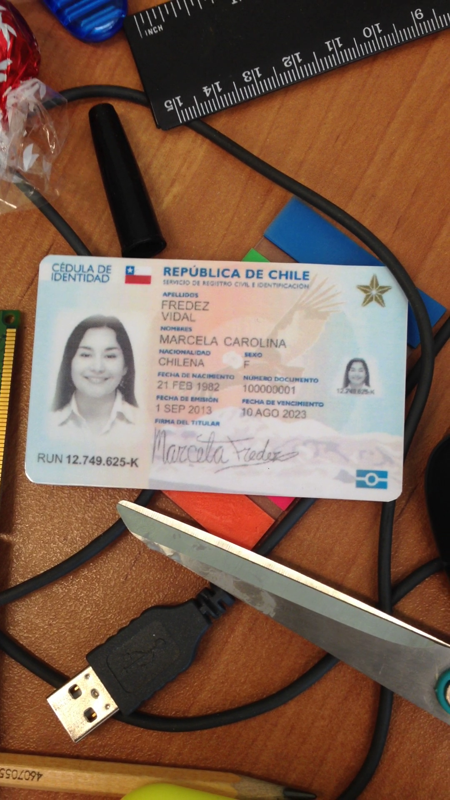

In [8]:
# Можно посмотреть изображения и разметку; в .quadrangle используются относительные единицы
print(di.quadrangle)
di.image

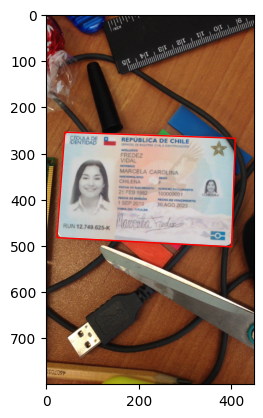

In [9]:
# Можно отрисовать разметку
# Не обязательно весь документ виден в кадре
di.show()

In [10]:
# DataItem содержит в себе информацию, относится ли он к test_split и целиком ли разметка внутри кадра
di.is_test_split(), di.is_quad_inside()

(False, True)

False


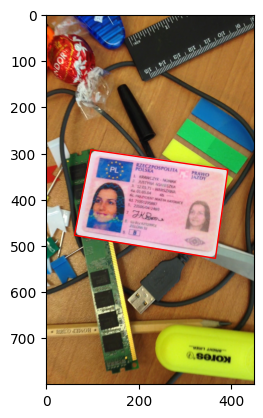

In [11]:
print(data_packs[38][238].is_test_split())
data_packs[38][238].show()

In [12]:
## Статистика, как часто разметка не целиком в кадре
is_quad_inside = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_quad_inside.append(dp[i].is_quad_inside())
is_quad_inside = np.array(is_quad_inside).astype(int)
print(f"В {is_quad_inside.sum()} из {len(is_quad_inside)} случаев разметка кропа(т.е. документ) целиком в кадре")

100%|██████████| 50/50 [00:06<00:00,  7.19it/s]

В 9992 из 15000 случаев разметка кропа(т.е. документ) целиком в кадре


In [13]:
## Статистика test-split
is_test_split = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_test_split.append(dp[i].is_test_split())
is_test_split = np.array(is_test_split).astype(int)
print(f"В {is_test_split.sum()} из {len(is_test_split)} случаев кадр принадлежит к test-split")

100%|██████████| 50/50 [00:00<00:00, 269.67it/s]

В 4250 из 15000 случаев кадр принадлежит к test-split


In [5]:
def convert_targets_to_mask(image_shape, corner_coordinates):
    mask = np.zeros(image_shape)
    cv2.fillConvexPoly(mask, np.array(corner_coordinates), 1)
    return mask

In [6]:
class Midv500Dataset(Dataset):
    def __init__(self, data_packs, is_val=False):
        self.data_packs = data_packs
        self.list_of_indexes = []
        
        for i in range(len(data_packs)):
            for j in range(len(data_packs[i])):                
                if is_val and data_packs[i][j].is_test_split():
                    self.list_of_indexes.append((i, j))
                elif not is_val and not data_packs[i][j].is_test_split():
                    self.list_of_indexes.append((i, j))

    def __len__(self):
        return len(self.list_of_indexes)

    def __getitem__(self, idx):
        i, j = self.list_of_indexes[idx]
        img = torch.FloatTensor(np.array(self.data_packs[i][j].image)).permute([2, 0, 1]) # img = [C, H, W]
            
        img /= 255.
        targets = torch.FloatTensor(convert_targets_to_mask(img.size()[1:], self.data_packs[i][j].gt_data['quad']))
        
        
            
        return img, targets

In [7]:
train_dataset = Midv500Dataset(data_packs)
valid_dataset = Midv500Dataset(data_packs, True)

In [8]:
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(valid_dataset))

Train dataset size: 10750
Validation dataset size: 4250


In [9]:
batch_size = 4

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.input = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.out = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        return self.out((self.encoder(x) + self.input(x)))

In [11]:
class ResUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enocoder1 = Block(3, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enocoder2 = Block(32, 64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enocoder3 = Block(64, 128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enocoder4 = Block(128, 256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = Block(256, 512)
        
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder1 = Block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = Block(256, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, output_padding=1)
        self.decoder3 = Block(128, 64)
        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder4 = Block(64, 32)
        
        self.out = nn.Conv2d(32, 1, kernel_size=1)
        
        
    def forward(self, x):
        enc1 = self.enocoder1(x)
        enc2 = self.enocoder2(self.pool1(enc1))
        enc3 = self.enocoder3(self.pool2(enc2))
        enc4 = self.enocoder4(self.pool3(enc3))
        
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        dec = self.upconv1(bottleneck)
        dec = torch.cat((dec, enc4), dim=1)
        dec = self.decoder1(dec)
        
        dec = self.upconv2(dec)
        dec = torch.cat((dec, enc3), dim=1)
        dec = self.decoder2(dec)

        dec = self.upconv3(dec)[:, :, :400, :]
        dec = torch.cat((dec, enc2), dim=1)
        dec = self.decoder3(dec)
        
        dec = self.upconv4(dec)
        dec = torch.cat((dec, enc1), dim=1)
        dec = self.decoder4(dec)
        
        out = self.out(dec)
        return out

In [12]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1

    def forward(self, inputs, targets):
        assert inputs.size() == targets.size()
        inputs = torch.sigmoid(inputs)
        targets = targets.float()

        numerator = torch.sum(inputs * targets)
        denominator = torch.sum(inputs) + torch.sum(targets)

        dice = (2. * numerator + self.smooth) / (denominator + self.smooth)

        return 1. - dice

In [13]:
class CombinationLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        return 0.4 * self.dice(inputs, targets) + 0.6 * self.bce(inputs, targets)

In [14]:
class LitBox(lightning.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = CombinationLoss()
        
    def training_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        outputs = outputs.squeeze(1)
        loss = self.criterion(outputs, targets)
        
        self.log("train_loss", loss, on_step=True, on_epoch=False)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        outputs = outputs.squeeze(1)
        loss = self.criterion(outputs, targets)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.model.parameters(), lr=0.001)
        return optimizer

In [15]:
model = ResUNet()
total_params = sum(p.numel() for p in model.parameters())
print("Total params:", total_params)

Total params: 8114241


In [ ]:
lit_model = LitBox(model)
logger = TensorBoardLogger("tb_logs", name="ResUNet")
early_stopping = EarlyStopping('val_loss')
trainer = lightning.Trainer(logger=logger, max_epochs=10, callbacks=[early_stopping])
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

In [ ]:
%tensorboard --logdir tb_logs

In [64]:
# torch.save(model.state_dict(), "ResUNet_weights.pth")


In [ ]:
model.load_state_dict(torch.load("ResUNet_weights.pth"))
model.to(device)

### Сохраним результаты и измерим точность

In [17]:
def find_corners(mask):
    binary_mask = (torch.sigmoid(mask) > 0.3).cpu().numpy().astype(np.uint8)
    
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    
    x, y = contour[:, 0, 0], contour[:, 0, 1]
    
    corners_indices = np.array([np.argmin(x + y), np.argmin(-x + y), np.argmax(x + y), np.argmax(-x + y)])
    corners = np.array([x[corners_indices], y[corners_indices]]).T
    
    return corners.astype(float)

def to_relative_scale(quad, h, w):
    for i in range(len(quad)):
        quad[i][0] /= w
        quad[i][1] /= h 
    return quad

In [18]:
img = torch.FloatTensor(np.array(data_packs[0][0].image)) / 255.
img = img.permute([2, 0, 1])
img = img.to(device)
res = model(img.unsqueeze(0))
corners = to_relative_scale(find_corners(res.squeeze()), img.size()[1], img.size()[2])

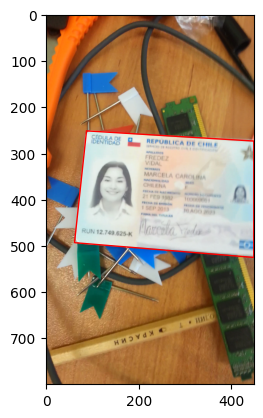

In [19]:
data_packs[0][0].show(corners)

In [20]:
from course_intro_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

In [22]:
results_dict = dict()

for dp in tqdm(data_packs):
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                img = torch.FloatTensor(np.array(dp[i].image)) / 255.
                img = img.permute([2, 0, 1])
                img = img.to(device)
                res = model(img.unsqueeze(0))
                corners = find_corners(res.squeeze())
                results_dict[dp[i].unique_key] = to_relative_scale(corners, img.size()[1], img.size()[2])
            except Exception as exc:
                print(exc)

100%|██████████| 50/50 [02:18<00:00,  2.78s/it]


In [23]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [24]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

In [25]:
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.8628
